In [274]:
import os
import re
import cv2
import math


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

from PIL import Image
from shutil import copyfile
import datetime
import warnings
warnings.filterwarnings("ignore")

#### EMP006 data process

In [203]:
def percentile_label(df):
    df.loc[df.jump_eda >= df.jump_eda.quantile(0.80), 'stress_level'] = 1
    df.loc[df.jump_eda < df.jump_eda.quantile(0.80), 'stress_level'] = 0
    return df

In [204]:
def df_append(dir_path):
    df_label = pd.DataFrame()
    for i in os.listdir(dir_path):
        df_path = os.path.join(dir_path,i)
        df = pd.read_csv(df_path, encoding = "utf-16", sep='\t')
        df = percentile_label(df)
        df_label = df_label.append(df, ignore_index=True)
    return df_label

In [205]:
df_we_label = df_append('../../model_data/emp006_we')
df_we_label['route'] = 'we'
df_we_label = df_we_label.drop(df_we_label.columns[6],axis=1)

In [206]:
df_ns_label = df_append('../../model_data/emp006_ns')
df_ns_label['route'] = 'ns'
df_ns_label = df_ns_label.drop(df_ns_label.columns[6],axis=1)

In [207]:
datelist_we = np.unique(list(df_we_label['Date_Local']))
datelist_ns = np.unique(list(df_ns_label['Date_Local']))

In [208]:
datelist_ns,datelist_we

(array([20170922, 20170925, 20170926, 20170927, 20170928, 20170929,
        20171003, 20171004, 20171009, 20171010, 20171011]),
 array([20170922, 20170925, 20170926, 20170927, 20170928, 20170929,
        20171003, 20171004, 20171005, 20171010, 20171011, 20171012]))

In [209]:
from matplotlib import gridspec

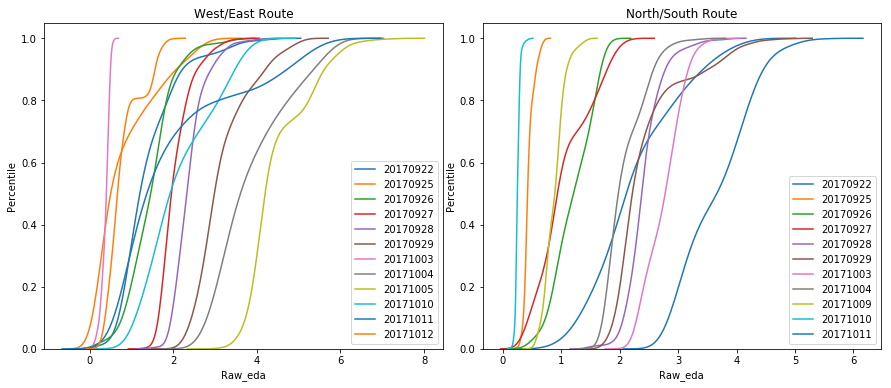

In [210]:
def cdf_eda_plot(df_we_label = df_we_label, df_ns_label = df_ns_label):
    fig = plt.figure(figsize=(15,6))
    gs = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.2)
    
    ax0 = plt.subplot(gs[0])
    for i in datelist_we:
        sns.kdeplot(df_we_label[df_we_label.Date_Local == i].Eda, legend=False, cumulative=True)   
    ax0.set_xlabel('Raw_eda')
    ax0.set_ylabel('Percentile')
    ax0.legend(datelist_we)
    ax0.set_title('West/East Route')
    
    ax1 = plt.subplot(gs[1])
    for i in datelist_ns:
        sns.kdeplot(df_ns_label[df_ns_label.Date_Local == i].Eda, legend=False, cumulative=True)   
    ax1.set_xlabel('Raw_eda')
    ax1.set_ylabel('Percentile')
    ax1.legend(datelist_ns)
    ax1.set_title('North/South Route')
cdf_eda_plot(df_we_label = df_we_label, df_ns_label = df_ns_label)

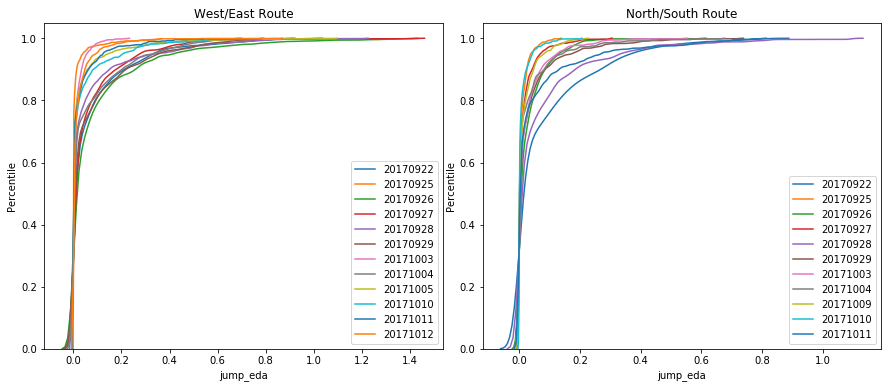

In [211]:
def cdf_jump_plot(df_we_label = df_we_label, df_ns_label = df_ns_label):
    fig = plt.figure(figsize=(15,6))
    gs = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.2)
    
    ax0 = plt.subplot(gs[0])
    for i in datelist_we:
        sns.kdeplot(df_we_label[df_we_label.Date_Local == i].jump_eda, legend=False, cumulative=True)   
    ax0.set_xlabel('jump_eda')
    ax0.set_ylabel('Percentile')
    ax0.legend(datelist_we)
    ax0.set_title('West/East Route')
    
    ax1 = plt.subplot(gs[1])
    for j in datelist_ns:
        sns.kdeplot(df_ns_label[df_ns_label.Date_Local == j].jump_eda, legend=False, cumulative=True)   
    ax1.set_xlabel('jump_eda')
    ax1.set_ylabel('Percentile')
    ax1.legend(datelist_ns)
    ax1.set_title('North/South Route')
cdf_jump_plot(df_we_label = df_we_label, df_ns_label = df_ns_label)

In [218]:
df_merge = pd.concat([df_we_label, df_ns_label], ignore_index=True)

In [219]:
df_merge.head()

,Date,Date_Local,driver,jump_eda,speed,Timestamp_Local,unix_time,Acc_X,Eda,HR,Latitude,Longitude,stress_level,route
0,20170922,20170922,EMP006,0.000000,0.00000,9/22/17 13:30,1506105021,6.15625,1.568308,108.62,41.210064,-96.005600,0.0,we
1,20170922,20170922,EMP006,0.358298,0.01852,9/22/17 13:30,1506105020,-16.71875,1.873822,108.55,41.210064,-96.005600,1.0,we
2,20170922,20170922,EMP006,0.000000,1.82000,9/22/17 13:30,1506105019,-16.03125,1.515524,108.48,41.210068,-96.005592,0.0,we
3,20170922,20170922,EMP006,0.000000,1.94000,9/22/17 13:30,1506105018,18.31250,1.869222,108.33,41.210068,-96.005585,0.0,we
4,20170922,20170922,EMP006,0.000000,1.88904,9/22/17 13:30,1506105017,50.28125,1.883618,108.17,41.210072,-96.005585,0.0,we


In [220]:
value = df_merge['unix_time'].apply(lambda row: datetime.datetime.fromtimestamp(row))
df_merge.insert(loc=5, column='timestamp', value=value)
df_merge['sec_of_day'] = df_merge['timestamp'].dt.hour*3600 + df_merge['timestamp'].dt.minute*60 + df_merge['timestamp'].dt.second
df_merge = df_merge.drop(['timestamp'], axis=1)


In [221]:
df_merge.head()

,Date,Date_Local,driver,jump_eda,speed,Timestamp_Local,unix_time,Acc_X,Eda,HR,Latitude,Longitude,stress_level,route,sec_of_day
0,20170922,20170922,EMP006,0.000000,0.00000,9/22/17 13:30,1506105021,6.15625,1.568308,108.62,41.210064,-96.005600,0.0,we,48621
1,20170922,20170922,EMP006,0.358298,0.01852,9/22/17 13:30,1506105020,-16.71875,1.873822,108.55,41.210064,-96.005600,1.0,we,48620
2,20170922,20170922,EMP006,0.000000,1.82000,9/22/17 13:30,1506105019,-16.03125,1.515524,108.48,41.210068,-96.005592,0.0,we,48619
3,20170922,20170922,EMP006,0.000000,1.94000,9/22/17 13:30,1506105018,18.31250,1.869222,108.33,41.210068,-96.005585,0.0,we,48618
4,20170922,20170922,EMP006,0.000000,1.88904,9/22/17 13:30,1506105017,50.28125,1.883618,108.17,41.210072,-96.005585,0.0,we,48617


### image load & resize

In [314]:
# image training chunk
from sklearn.utils import shuffle

In [296]:
df_train = df_merge[df_merge['Date_Local'] != 20170926]
df_test = df_merge[df_merge['Date_Local'] == 20170926]

In [297]:
train_random_copy1 = shuffle(df_train[df_train.stress_level == 1], n_samples = 2600, random_state=815)
train_random_copy0 = shuffle(df_train[df_train.stress_level == 0], n_samples = 2600, random_state=815)
df_train_bal = shuffle(pd.concat([train_random_copy1, train_random_copy0]))

In [298]:
train_random_copy1.shape

(2600, 15)

In [299]:
df_train_bal.shape

(5200, 15)

In [300]:
# train_image path in/out
raw_image_dir = '../../Blackbox_images/EMP006'
date_list_dir = list(set(datelist_we)|set(datelist_ns))
output_path = '../../model_data/train_image'

In [301]:
train_imglist = []
for i in np.unique(list(df_train_bal['unix_time'])):
    a = str(i) + '.jpg'
    train_imglist.append(a)

In [302]:
len(train_imglist)

5200

In [303]:
test_imglist = []
for i in np.unique(list(df_test['unix_time'])):
    test = str(i) + '.jpg'
    test_imglist.append(test)

In [304]:
len(train_imglist), len(test_imglist)

(5200, 1201)

In [275]:
# Image selected from cybox
for folder in date_list_dir:
    date_folder = os.path.join(raw_image_dir, str(folder))
    for file in os.listdir(date_folder):
        if file in train_imglist:
            copyfile(os.path.join(date_folder,file), os.path.join(output_path, file))
            #img_re = image_resize(os.path.join(date_folder,file))
            #cv2.imwrite(os.path.join(output_path, file),cv2.cvtColor(img_re, cv2.COLOR_RGB2BGR))        

In [305]:
image_loaded = pd.DataFrame(os.listdir(output_path), columns=['loaded_image'])

In [306]:
image_loaded.head()

,loaded_image
0,1506104374.jpg
1,1506104379.jpg
2,1506104383.jpg
3,1506104392.jpg
4,1506104393.jpg


### train set prepare

In [333]:
df_train_bal1 = df_train_bal.reset_index(drop=True).copy()

In [334]:
df_train_bal1['image_file'] = df_train_bal1.unix_time.apply(str) + '.jpg'
df_train_mod = pd.merge(df_train_bal1,image_loaded, left_on='image_file', right_on='loaded_image', how='inner')

In [335]:
df_train_mod.shape

(4942, 17)

In [337]:
mod1 = shuffle(df_train_mod[df_train_mod.stress_level == 1], n_samples = 2300, random_state=531)
mod0 = shuffle(df_train_mod[df_train_mod.stress_level == 0], n_samples = 2300, random_state=531)
df_merged = shuffle(pd.concat([mod1, mod0])).reset_index(drop=True)

In [338]:
df_train_set = df_merged[['jump_eda','Date_Local','unix_time','image_file','Acc_X','speed','sec_of_day','stress_level']].reset_index(drop=True)


In [339]:
df_train_set.shape

(4600, 8)

In [353]:
df_train_set[df_train_set.image_file == '1506537263.jpg']

,jump_eda,Date_Local,unix_time,image_file,Acc_X,speed,sec_of_day,stress_level
506,0.02463,20170927,1506537263,1506537263.jpg,-30.25,68.870003,48863,0.0


### HOG feature visualization

In [359]:
# HOG feature extract
from skimage.feature import hog
from skimage import data, exposure

In [382]:
# Sample data read
high_dirpath = os.path.join(output_path, '1506622530.jpg')
normal_dirpath = os.path.join(output_path, '1506537263.jpg')

img_high = cv2.imread(high_dirpath)
img_normal = cv2.imread(normal_dirpath)
img_high = cv2.resize(img_high, (188,240)) 
img_normal = cv2.resize(img_normal, (188,240)) 

img_high_rgb = cv2.cvtColor(img_high, cv2.COLOR_BGR2RGB)
img_normal_rgb = cv2.cvtColor(img_normal, cv2.COLOR_BGR2RGB)

img_high_gray = cv2.cvtColor(img_high_rgb, cv2.COLOR_BGR2GRAY)
img_normal_gray = cv2.cvtColor(img_normal_rgb, cv2.COLOR_BGR2GRAY)

In [383]:
# high
fd_high16, hog_image_high16 = hog(img_high_gray, orientations=6, pixels_per_cell=(16, 16), cells_per_block=(1, 1),
                                block_norm='L2', visualise=True)
hog_rescale_high16 = exposure.rescale_intensity(hog_image_high16, in_range=(0, 10))

fd_high8, hog_image_high8 = hog(img_high_gray, orientations=6, pixels_per_cell=(8, 8), cells_per_block=(1, 1),
                                block_norm='L2', visualise=True)
hog_rescale_high8 = exposure.rescale_intensity(hog_image_high8, in_range=(0, 10))

fd_high4, hog_image_high4 = hog(img_high_gray, orientations=6, pixels_per_cell=(4, 4), cells_per_block=(1, 1),
                                block_norm='L2', visualise=True)
hog_rescale_high4 = exposure.rescale_intensity(hog_image_high4, in_range=(0, 10))

# normal
fd_normal16, hog_image_normal16 = hog(img_normal_gray, orientations=6, pixels_per_cell=(16,16), cells_per_block=(1, 1),
                                block_norm='L2', visualise=True)
hog_rescale_normal16 = exposure.rescale_intensity(hog_image_normal16, in_range=(0, 10))

fd_normal8, hog_image_normal8 = hog(img_normal_gray, orientations=6, pixels_per_cell=(8,8), cells_per_block=(1, 1),
                                block_norm='L2', visualise=True)
hog_rescale_normal8 = exposure.rescale_intensity(hog_image_normal8, in_range=(0, 10))

fd_normal4, hog_image_normal4 = hog(img_normal_gray, orientations=6, pixels_per_cell=(4,4), cells_per_block=(1, 1),
                                block_norm='L2', visualise=True)
hog_rescale_normal4 = exposure.rescale_intensity(hog_image_normal4, in_range=(0, 10))


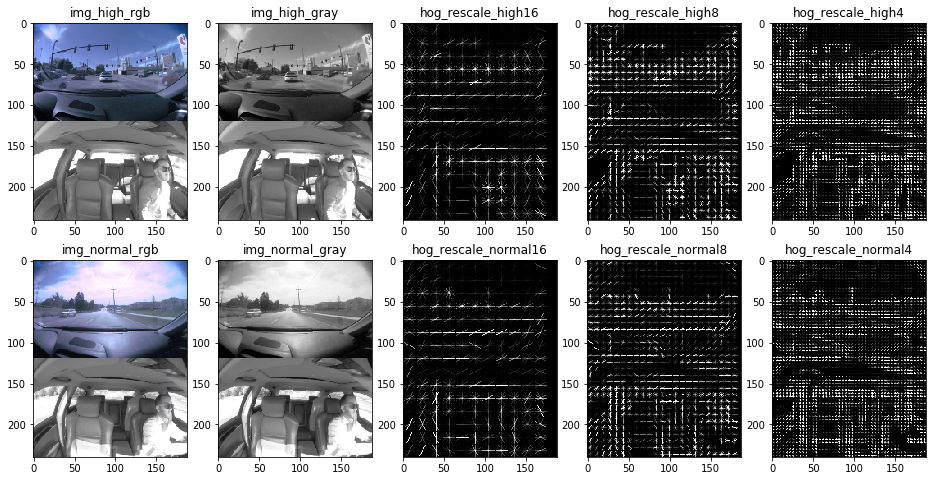

In [390]:
def HOG_feature_plot():
    fig = plt.figure(figsize=(16,8))
    gs = gridspec.GridSpec(2, 5, wspace=0.2, hspace=0.2)
    ax0 = plt.subplot(gs[0,0])
    ax1 = plt.subplot(gs[0,1])
    ax2 = plt.subplot(gs[0,2])
    ax3 = plt.subplot(gs[0,3])
    ax4 = plt.subplot(gs[0,4])
    ax00 = plt.subplot(gs[1,0])
    ax11 = plt.subplot(gs[1,1])
    ax22 = plt.subplot(gs[1,2])
    ax33 = plt.subplot(gs[1,3])
    ax44 = plt.subplot(gs[1,4])
    # high
    ax0.imshow(img_high_rgb)
    ax0.set_title('img_high_rgb')
    ax1.imshow(img_high_gray, cmap=plt.cm.gray)
    ax1.set_title('img_high_gray')
    ax2.imshow(hog_rescale_high16, cmap=plt.cm.gray)
    ax2.set_title('hog_rescale_high16')
    ax3.imshow(hog_rescale_high8, cmap=plt.cm.gray)
    ax3.set_title('hog_rescale_high8')
    ax4.imshow(hog_rescale_high4, cmap=plt.cm.gray)
    ax4.set_title('hog_rescale_high4')
    # normal
    ax00.imshow(img_normal_rgb)
    ax00.set_title('img_normal_rgb')
    ax11.imshow(img_normal_gray, cmap=plt.cm.gray)
    ax11.set_title('img_normal_gray')
    ax22.imshow(hog_rescale_normal16, cmap=plt.cm.gray)
    ax22.set_title('hog_rescale_normal16')
    ax33.imshow(hog_rescale_normal8, cmap=plt.cm.gray)
    ax33.set_title('hog_rescale_normal8')
    ax44.imshow(hog_rescale_normal4, cmap=plt.cm.gray)
    ax44.set_title('hog_rescale_normal4')
    fig.show()
    
HOG_feature_plot()

In [391]:
def resize_cvt2gray(inputpath):
    img = cv2.imread(inputpath)
    height, width, channel = img.shape
    img_resize = cv2.resize(img, (int(width/4),int(height/4)))
    img_gray = cv2.cvtColor(img_resize, cv2.COLOR_BGR2GRAY)
    return img_gray

In [423]:
train_imglist = df_train_set.image_file.values.tolist()

In [424]:
df_train_set.head()

,jump_eda,Date_Local,unix_time,image_file,Acc_X,speed,sec_of_day,stress_level
0,0.000000,20171011,1507746686,1507746686.jpg,-26.03125,0.370400,48686,0.0
1,0.015675,20171003,1507055361,1507055361.jpg,-58.06250,69.690758,48561,1.0
2,0.246778,20170927,1506537199,1506537199.jpg,-52.18750,18.730000,48799,1.0
3,0.023031,20170927,1506541554,1506541554.jpg,-18.21875,35.521358,53154,1.0
4,0.090545,20170929,1506711392,1506711392.jpg,-31.34375,64.459999,50192,1.0


In [426]:
hog_feature = []
for image in train_imglist:
    img_gray = resize_cvt2gray(os.path.join(output_path,image))
    
    fd_ = hog(img_gray, orientations=6, pixels_per_cell=(8, 8), cells_per_block=(1, 1), block_norm='L2')
    hog_feature.append(fd_)
    
    df_hog_feature = pd.DataFrame(np.array(hog_feature))

In [430]:
df_hog_feature.head()

,0,1,2,3,4,5,6,7,8,9,...,4130,4131,4132,4133,4134,4135,4136,4137,4138,4139
0,0.772464,0.617126,0.136042,0.013634,0.022724,0.056966,0.208079,0.976958,0.047510,0.000000,...,0.462181,0.421260,0.354291,0.580512,0.022677,0.098891,0.188594,0.245134,0.940945,0.093111
1,0.737306,0.675559,0.000000,0.000000,0.000000,0.000000,0.043835,0.999039,0.000000,0.000000,...,0.188170,0.888675,0.392268,0.079181,0.558000,0.223173,0.195628,0.397946,0.611909,0.260318
2,0.881479,0.470803,0.019029,0.007477,0.000000,0.030372,0.456677,0.784421,0.419382,0.015769,...,0.236184,0.949015,0.098139,0.043783,0.146068,0.101962,0.243301,0.814052,0.468551,0.163866
3,0.722288,0.690174,0.035588,0.026333,0.000000,0.000000,0.747867,0.271850,0.369149,0.422758,...,0.493598,0.591224,0.630044,0.060510,0.012944,0.290196,0.222205,0.797828,0.479001,0.016524
4,0.456934,0.848836,0.265873,0.000000,0.000000,0.000000,0.024374,0.990544,0.135013,0.000000,...,0.463395,0.760892,0.418836,0.019462,0.349633,0.636912,0.147781,0.514319,0.410461,0.131373


In [431]:
df_hog_feature1 = df_hog_feature.copy()
df_train_set1 = df_train_set.copy()

In [433]:
df_train_set1.head()

,jump_eda,Date_Local,unix_time,image_file,Acc_X,speed,sec_of_day,stress_level
0,0.000000,20171011,1507746686,1507746686.jpg,-26.03125,0.370400,48686,0.0
1,0.015675,20171003,1507055361,1507055361.jpg,-58.06250,69.690758,48561,1.0
2,0.246778,20170927,1506537199,1506537199.jpg,-52.18750,18.730000,48799,1.0
3,0.023031,20170927,1506541554,1506541554.jpg,-18.21875,35.521358,53154,1.0
4,0.090545,20170929,1506711392,1506711392.jpg,-31.34375,64.459999,50192,1.0


### SVM Classifer

In [434]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [448]:
XX = df_train_set1[['Acc_X','speed','sec_of_day']]
yy = df_train_set1[['stress_level']]

In [449]:
XX_scaled = preprocessing.scale(XX)

In [450]:
XX.head()

,Acc_X,speed,sec_of_day
0,-26.03125,0.370400,48686
1,-58.06250,69.690758,48561
2,-52.18750,18.730000,48799
3,-18.21875,35.521358,53154
4,-31.34375,64.459999,50192


In [453]:
X = pd.DataFrame(np.hstack((XX_scaled,df_hog_feature1)))

In [456]:
y = yy.copy()

In [457]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

In [459]:
clf = SVC()
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [460]:
pred = clf.predict(X_train)
acc = accuracy_score(pred, y_train)
print("train accuracy = ",acc)
pred = clf.predict(X_test)
acc = accuracy_score(pred, y_test)
print("test accuracy = ",acc)

train accuracy =  0.6090062111801242
test accuracy =  0.5905797101449275
